#**Install Packages**

In [ ]:
%%capture
!pip install super-gradients==3.2.0
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

#**Import libraries**

In [ ]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

In [ ]:
from IPython.display import clear_output


In [ ]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback



In [ ]:
from super_gradients.training import models


#**Setting checkpoint directory dan Inisiasi trainer**

In [ ]:
CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='ppe_yolonas_run', ckpt_root_dir=CHECKPOINT_DIR)

#**Expor Dataset dari Roboflow**

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="OUx13M4wAVBt0qeZboyR")
project = rf.workspace("project-uyrxf").project("ppe_detection-v1x3l")
dataset = project.version(2).download("yolov5")

#**Load dataset parameters ke dictionary**

In [ ]:
dataset_params = {
    'data_dir':'/content/PPE_Detection-2',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': ['Dust Mask', 'Eye Wear', 'Glove', 'Protective Boots', 'Protective Helmet', 'Safety Vest', 'Shield']
}


#**Pass the values for `dataset_params` into the `dataset_params` argument as shown below.**

In [ ]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()

#**Inspect the Dataset Defined Earlier**

In [ ]:
train_data.dataset.transforms

In [ ]:
train_data.dataset.dataset_params['transforms'][1]

In [ ]:
train_data.dataset.dataset_params['transforms'][1]['DetectionRandomAffine']['degrees'] = 10.42

In [ ]:
train_data.dataset.plot()

#**Instantiating model**

In [ ]:
model = models.get('yolo_nas_s',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   )

#**Define metrics and training parameters**


In [ ]:
train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 15,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [ ]:
!gdown "https://drive.google.com/uc?id=1Nyl18zr7zOJHh8uHtSic3dsJSY4LI_t-&confirm=t"

In [ ]:
!gdown "https://drive.google.com/uc?id=1SxcrDanPAr-PZfJjWBxoa2t8lUSM2dZn&confirm=t"

#**Training the model**



In [ ]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

#**Get trained model**

In [ ]:
!gdown ...

In [ ]:
best_model = models.get('yolo_nas_s',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="/content/checkpoints/ppe_yolonas_run/ckpt_best.pth")

#**Evaluating the best trained model on the test set**

In [ ]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))

#**Predicting with the best model**



[2024-05-08 17:50:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


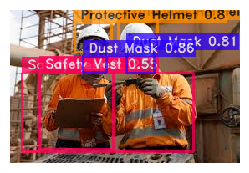

In [ ]:
img_url = '/content/apd-test.jpeg'
best_model.predict(img_url).show()

#**Testing on Video 1**

In [ ]:
input_video_path = f"/content/PPE_Part1.mp4"
output_video_path = "detections1.mp4"

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else "cpu"

In [ ]:
best_model.to(device).predict(input_video_path).save(output_video_path)

#**Display the Output Video**

In [ ]:
!rm '/content/result_compressed.mp4'

In [ ]:
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = '/content/detections1.mp4'

# Compressed video path
compressed_path = "/content/result_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)